In [165]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv

In [166]:
im = np.array(Image.open("im05.png")).astype("double")[:,:,0:3]
im_tex = np.array(Image.open("texture.png")).astype("double")[:,:,0:3]

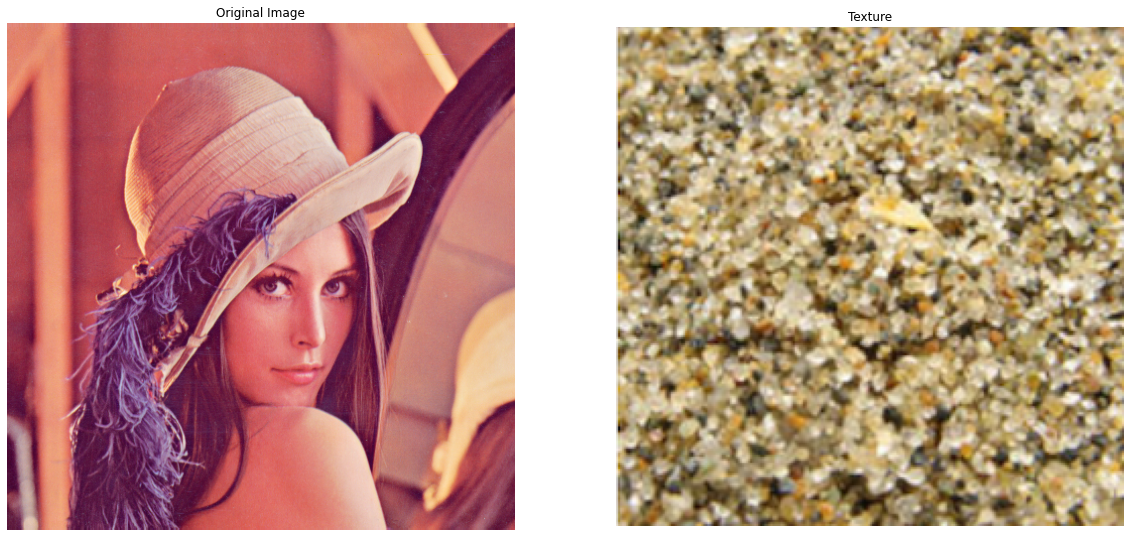

In [167]:
# showing the original image and the texture image
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im.astype("uint8"))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(im_tex.astype("uint8"))
plt.axis("off")
plt.title("Texture")

plt.show()

In [176]:
def find_block_size(im, block_num, overlap):
    '''Find the number of blocks that we should use in order to have the create the given image.'''
    m,n,_ = im.shape
    x,y = block_num
    size_x = int(m / ((x-1) * (1-overlap) + 1))
    size_y = int(n / ((y-1) * (1-overlap) + 1))
    return size_x, size_y


def norm2_err(im1,im2):
    '''Calculate the norm2 error of two images (assuming they have an equal size)'''
    return np.sum((im1 - im2)**2)

def block_cost(im, im_trans, block, alpha, overlap, i, j, block_type):
    '''Calculate the cost of putting a block in position (i,j) with the given alpha "alpha" and overlap percentage
    "overlap".'''
    m,n = im.shape[0], im.shape[1]
    m_block, n_block = block.shape[0], block.shape[1]
    overlap_x = int(m_block * overlap)
    overlap_y = int(n_block * overlap)
    #print(overlap_x, overlap_y, i, j)
    # if block_type is 0, then there is no overlap
    if (block_type == 0):
        Ls = 0
    # if block_type is 1, then it only has overlap from left
    elif (block_type == 1):
        Ls = norm2_err(im_trans[i:i+m_block,j:j+overlap_y], block[0:m_block, 0:overlap_y])
    # if block_type is 2, then it only has overlap from top
    elif (block_type == 2):
        Ls = norm2_err(im_trans[i:i+overlap_x,j:j+n_block], block[0:overlap_x, 0:n_block])
    else:
        Ls = norm2_err(im_trans[i:i+overlap_x,j:j+n_block], block[0:overlap_x, 0:n_block])
        Ls = Ls + norm2_err(im_trans[i+overlap_x:i+m_block, j:j+overlap_y], block[overlap_x:m_block, 0:overlap_y])
    Lt = norm2_err(im[i:i+m_block, j:j+n_block], block)
    cost = alpha * Ls + (1 - alpha) * Lt
    return cost

def find_best_block(im, im_trans, im_tex, block_num, alpha, overlap, i, j):
    '''Find the best block for a given position.'''
    x_block, y_block = find_block_size(im, block_num, overlap)
    m,n = im.shape[0], im.shape[1]
    m_tex, n_tex = im_tex.shape[0], im_tex.shape[1]
    #print(i,j)
    if (i + x_block > m):
        x_block = m - i
    
    if (j + y_block > n):
        y_block = n - j
        
    #print(x_block, y_block)
    # finding the block_type
    if (i==0 and j==0):
        block_type = 0
    elif (i==0):
        block_type = 1
    elif (j==0):
        block_type = 2
    else:
        block_type = 3
    
    # finding the best block
    min_cost = float('inf')
    x_best = 0
    y_best = 0
    im_tex_gray = np.round_((im_tex[:,:,0] + im_tex[:,:,1] + im_tex[:,:,2])/3)
    im_gray = np.round_((im[:,:,0] + im[:,:,1] + im[:,:,2])/3)
    im_trans_gray = np.round_((im_trans[:,:,0] + im_trans[:,:,1] + im_trans[:,:,2])/3)
    for x in range(0,m_tex - x_block + 1,5):
        for y in range(0,n_tex - y_block + 1,5):
                #block = im_tex_gray[x:x+x_block, y:y+y_block, :].copy()
                block = im_tex_gray[x:x+x_block, y:y+y_block].copy()
                #print("Block size:", block.shape)
                cost = block_cost(im_gray, im_trans_gray, block, alpha, overlap, i, j, block_type)
                #print(cost)
                if (cost<min_cost):
                    min_cost = cost
                    x_best = x
                    y_best = y
    best_block = im_tex[x_best:x_best + x_block, y_best:y_best + y_block,:].copy()
    return best_block, block_type
    
def add_block(im_trans, block, i, j, block_type, overlap):
    '''Adds the block in position (i,j) to the trasfered image.'''
    m_block, n_block = block.shape[0], block.shape[1]
    overlap_x = int(m_block * overlap)
    overlap_y = int(n_block * overlap)
    x_end = m_block
    y_end = n_block
    if (block_type == 0):
        x_start = 0
        y_start = 0
    elif (block_type == 1):
        x_start = 0
        y_start = overlap_y // 2
    elif (block_type == 2):
        x_start = overlap_x // 2
        y_start = 0
    else:
        x_start = overlap_x // 2
        y_start = overlap_y // 2
    im_trans[i+x_start:i+x_end, j+y_start:j+y_end,:] = block[x_start:x_end, y_start:y_end, :]
    return im_trans

def texture_transfer(im, im_tex, overlap, alpha, block_num):
    block_x, block_y = find_block_size(im, block_num, overlap)
    im_trans = np.zeros(im.shape)
    for i in range(0,im.shape[0],int((1-overlap)*block_x)):
        print("Finding the best blocks for row:",i)
        for j in range(0,im.shape[1], int((1-overlap)*block_y)):
            best_block, block_type = find_best_block(im, im_trans, im_tex, block_num, alpha, overlap, i, j)
            #print(best_block.shape)
            im_trans = add_block(im_trans, best_block, i, j, block_type, overlap)
    return im_trans  

As can be seen, the image is transfered using the function "texture_transfer" which gets the image, the texture image, the percentage of overlap, alpha, and the number of blocks that we want to use in each row and column. The hyper parametes in this case are "overlap", "alpha" and "block_num". As we increase alpha, the image would be more smooth but less similar to the original image. In addition, as the number of blocks per row and column is increased, we give the textured image to have more detail but with the price of less similarity to the texture. Here, I created two examples with different numbers of blocks and alpha.

**Creating the image with 60 rows and columns of blocks which leads to a more detailed image:**

In [177]:
transfered = texture_transfer(im[:,:,:], im_tex, 0.3, 0.3, (60,60))

Finding the best blocks for row: 0
Finding the best blocks for row: 8
Finding the best blocks for row: 16
Finding the best blocks for row: 24
Finding the best blocks for row: 32
Finding the best blocks for row: 40
Finding the best blocks for row: 48
Finding the best blocks for row: 56
Finding the best blocks for row: 64
Finding the best blocks for row: 72
Finding the best blocks for row: 80
Finding the best blocks for row: 88
Finding the best blocks for row: 96
Finding the best blocks for row: 104
Finding the best blocks for row: 112
Finding the best blocks for row: 120
Finding the best blocks for row: 128
Finding the best blocks for row: 136
Finding the best blocks for row: 144
Finding the best blocks for row: 152
Finding the best blocks for row: 160
Finding the best blocks for row: 168
Finding the best blocks for row: 176
Finding the best blocks for row: 184
Finding the best blocks for row: 192
Finding the best blocks for row: 200
Finding the best blocks for row: 208
Finding the best

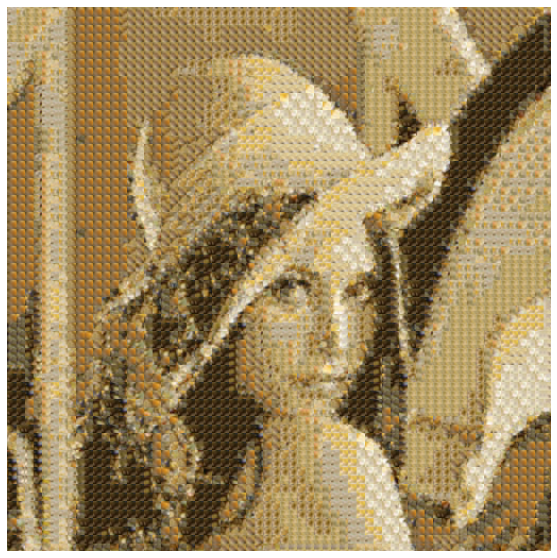

In [180]:
plt.figure(figsize=(15,10))
plt.imshow(transfered.astype("uint8"))
plt.axis("off")
plt.show()

**Creating the image with 25 rows and columns of blocks which leads to a more general and smoother image:**

In [185]:
transfered_low = texture_transfer(im[:,:,:], im_tex, 0.3, 0.3, (25,25))

Finding the best blocks for row: 0
Finding the best blocks for row: 19
Finding the best blocks for row: 38
Finding the best blocks for row: 57
Finding the best blocks for row: 76
Finding the best blocks for row: 95
Finding the best blocks for row: 114
Finding the best blocks for row: 133
Finding the best blocks for row: 152
Finding the best blocks for row: 171
Finding the best blocks for row: 190
Finding the best blocks for row: 209
Finding the best blocks for row: 228
Finding the best blocks for row: 247
Finding the best blocks for row: 266
Finding the best blocks for row: 285
Finding the best blocks for row: 304
Finding the best blocks for row: 323
Finding the best blocks for row: 342
Finding the best blocks for row: 361
Finding the best blocks for row: 380
Finding the best blocks for row: 399
Finding the best blocks for row: 418
Finding the best blocks for row: 437
Finding the best blocks for row: 456
Finding the best blocks for row: 475
Finding the best blocks for row: 494


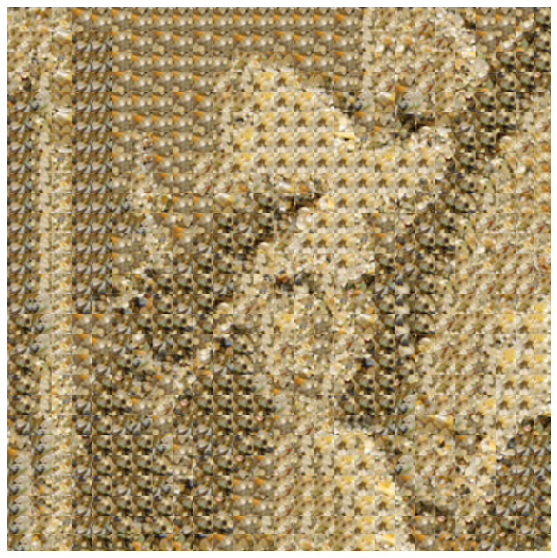

In [186]:
plt.figure(figsize=(15,10))
plt.imshow(transfered_low.astype("uint8"))
plt.axis("off")
plt.show()

Here is a final plot containing the original, the textured image with lower number of blocks and with higher number of blocks:

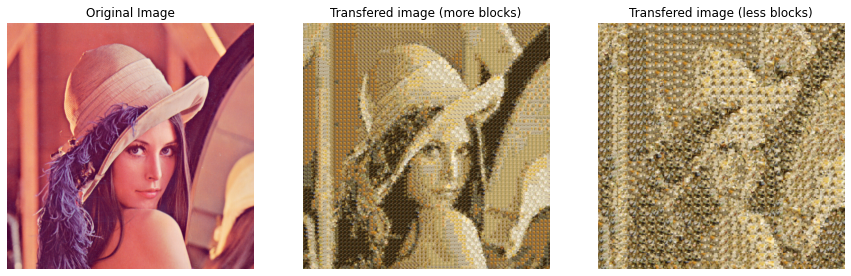

In [191]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(im.astype("uint8"))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(transfered.astype("uint8"))
plt.axis("off")
plt.title("Transfered image (more blocks)")

plt.subplot(1,3,3)
plt.imshow(transfered_low.astype("uint8"))
plt.axis("off")
plt.title("Transfered image (less blocks)")

plt.show()

In [193]:
Image.fromarray(transfered.astype("uint8")).save("results/res26-texture.jpg", "JPEG")